In [150]:
import numpy as np
import torch
import torchvision
import math

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import UninformativePrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [151]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

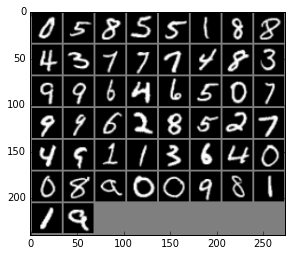

In [152]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [153]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [154]:
trainset[0][0].size()

torch.Size([1, 32, 32])

In [155]:
def weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()

def conv_out_size_same(size, stride):
    return int(math.ceil(size / stride))
        
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = x.view((-1, self.input_dim, 1, 1))
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))
        x = x.squeeze()

        return x


In [156]:
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()

z = Variable(torch.from_numpy(np.random.rand(10, 100)).float())
print(gen.forward(z).size())
print(disc(gen.forward(z)).size())


torch.Size([10, 1, 32, 32])
torch.Size([10])


In [157]:
from bgan import BGAN

In [158]:
batch_size = 50
z_dim = 100

In [185]:
prior = UninformativePrior()
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, disc, prior, alpha=.01, eta=0.0002, gen_observed=500, MAP=True, cuda=True)
samples = []

Moving generator and discriminator to GPU


In [186]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.cpu().data.numpy()))

torch.Size([100, 512, 4, 4]) 13.0674
torch.Size([512]) 0.346163
torch.Size([512]) 13.2279
torch.Size([512]) 0.0
torch.Size([512, 256, 4, 4]) 9.23907
torch.Size([256]) 0.104383
torch.Size([256]) 9.46395
torch.Size([256]) 0.0
torch.Size([256, 128, 4, 4]) 6.53469
torch.Size([128]) 0.0991878
torch.Size([128]) 6.12234
torch.Size([128]) 0.0
torch.Size([128, 1, 4, 4]) 0.580866
torch.Size([1]) 5.83404e-05


## Training

In [187]:
num_samples = 10

In [219]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(10):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.step(batch)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv.cuda())
        print('\t', d_loss.cpu().data.numpy()[0], g_loss.cpu().data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).cpu().data.numpy())
samples = np.vstack(samples)

	 0.00485104 5.93193
0
	 0.00351993 11.8301
1
	 0.00830977 5.73991
2
	 0.00136412 8.31726
3
	 0.020122 5.72534
4
	 0.00149003 8.32712
5
	 0.00258585 7.57057
6
	 0.00272351 7.00936
7
	 0.0120304 6.22989
8
	 0.00422437 6.41691
9


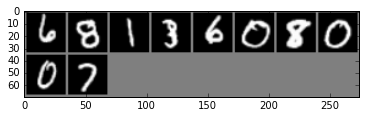

In [220]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [221]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [222]:
# samples = bgan.sample(100).cpu().data.numpy()

In [223]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [224]:
samples_arr.shape

(400, 1, 32, 32)

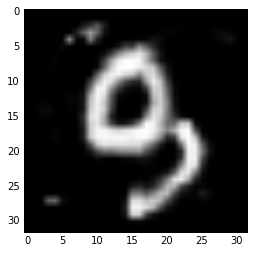

In [225]:
plt.imshow((samples_arr[-1, 0] + 1)/2, cmap='gray')

In [226]:
np.max(batch.numpy())

1.0

In [227]:
samples_arr.shape

(400, 1, 32, 32)

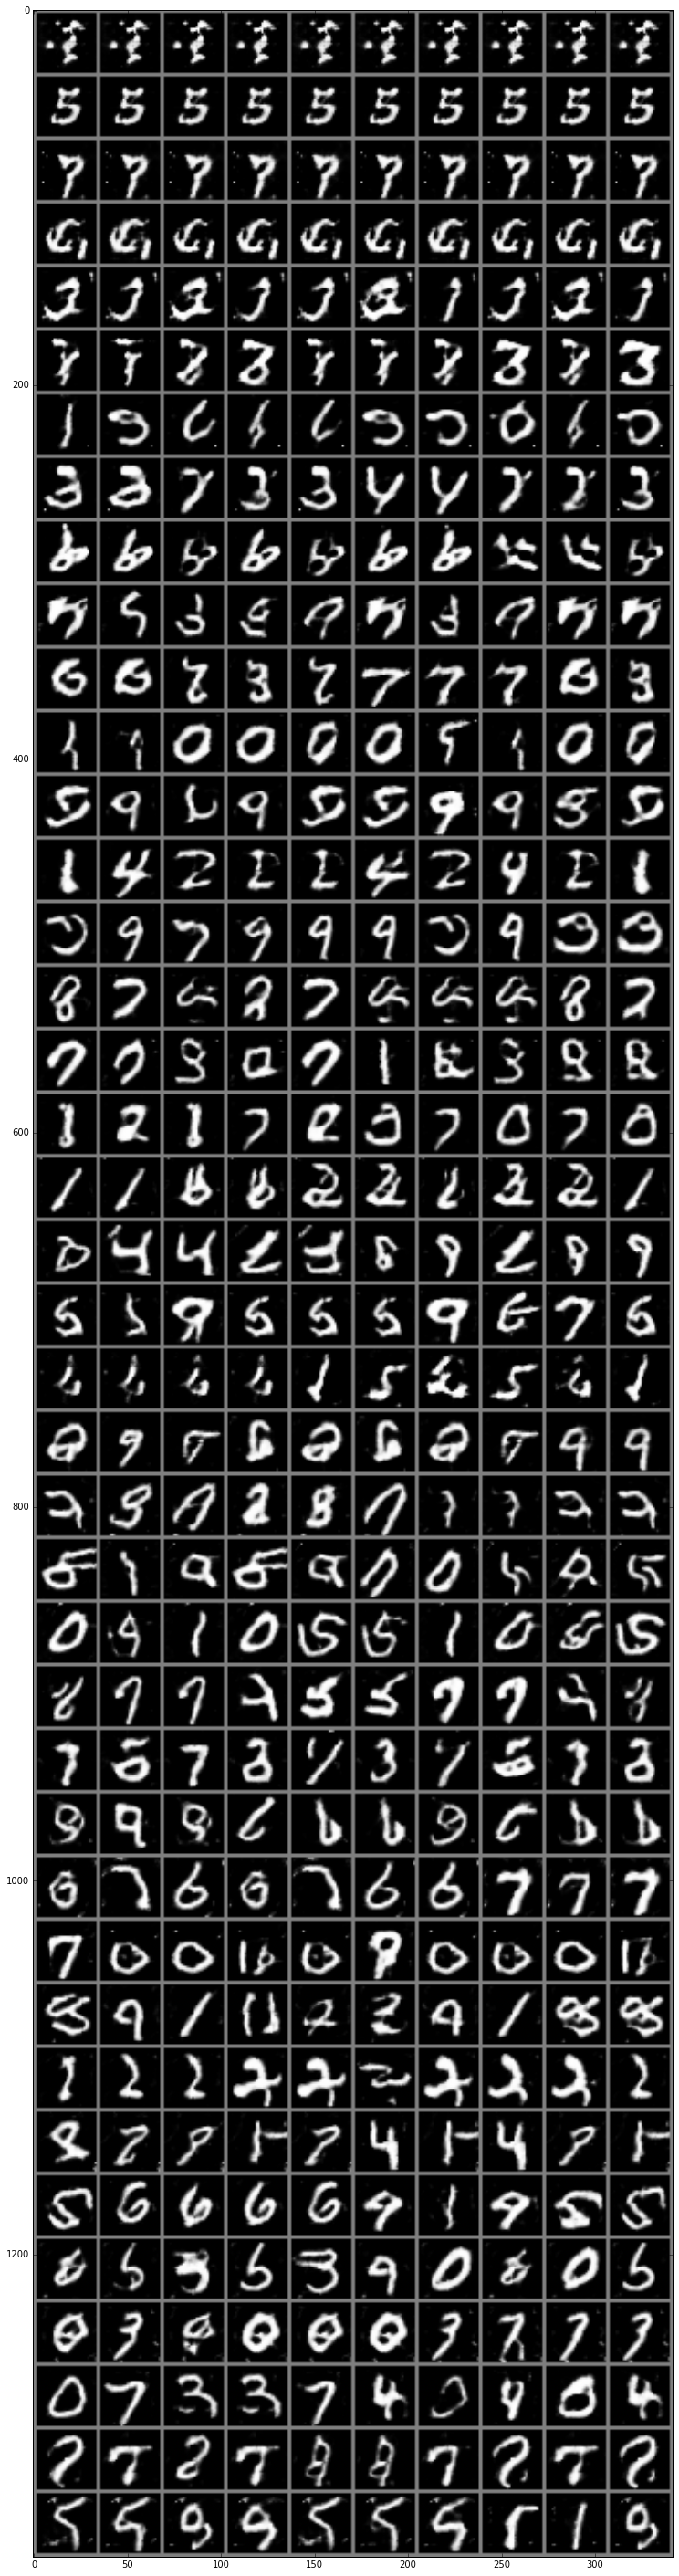

In [228]:
plt.figure(figsize=(20, 50))
show_epochs = [20, 30]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
# imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[:]), nrow=10))


In [229]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())

In [230]:
sample_probs

Variable containing:
 9.9835e-01
 5.9036e-01
 8.7739e-01
 1.7999e-03
 5.2887e-01
 1.2573e-02
 6.9656e-01
 4.5446e-01
 6.6233e-01
 7.7236e-03
 7.5134e-01
 2.0254e-04
 2.2765e-01
 3.5449e-03
 4.3335e-01
 1.9215e-02
 4.6830e-04
 2.6265e-01
 1.0403e-01
 1.1144e-01
 6.6203e-03
 6.3578e-02
 3.5287e-02
 3.5488e-02
 5.3639e-02
 1.2695e-01
 1.3571e-02
 4.4750e-03
 1.1982e-03
 2.8428e-02
 1.8881e-02
 9.6676e-01
 9.0255e-01
 3.8963e-01
 9.8171e-01
 8.1932e-04
 4.0432e-01
 1.1476e-03
 9.7196e-01
 4.2706e-01
 2.7863e-02
 6.6570e-01
 7.6292e-01
 9.9724e-01
 7.6382e-01
 1.0394e-02
 1.3431e-02
 9.1029e-03
 2.6540e-02
 8.1744e-02
 4.3665e-01
 1.4581e-02
 2.6880e-06
 1.2079e-01
 8.9773e-01
 2.0972e-06
 9.9990e-01
 2.7361e-02
 9.9990e-01
 1.0030e-01
 2.5698e-01
 2.0400e-01
 3.0314e-03
 6.4327e-01
 2.2273e-01
 6.3778e-01
 2.4398e-01
 6.2784e-02
 4.9128e-01
 2.3797e-01
 4.1679e-01
 9.9994e-01
 9.8510e-01
 9.8298e-01
 9.9986e-01
 9.9361e-02
 1.7690e-01
 3.7958e-01
 1.8259e-01
 2.6308e-02
 9.9486e-01
 2.2368

In [231]:
disc(Variable(batch).cuda())

Variable containing:
 0.9991
 1.0000
 1.0000
 0.9998
 0.9998
 1.0000
 0.9984
 1.0000
 1.0000
 1.0000
 1.0000
 0.9982
 0.9945
 0.9998
 1.0000
 1.0000
 0.9998
 0.9990
 0.9809
 0.9839
 1.0000
 0.9997
 0.9963
 1.0000
 0.9990
 1.0000
 0.9998
 1.0000
 0.9870
 0.9999
 1.0000
 1.0000
 0.9999
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 0.9999
 1.0000
 0.9607
 0.9999
 1.0000
 0.9998
 0.9999
 1.0000
 1.0000
 0.9997
 0.9999
 1.0000
[torch.cuda.FloatTensor of size 50 (GPU 0)]